## Grab MP docs

In [1]:
from mp_api.client import MPRester
import os

import numpy as np
import matplotlib.pyplot as plt
import plotly 
import plotly.graph_objects as go

with MPRester(os.environ['MPAPI']) as mpr:
    docs = mpr.summary.search(elements=['Ag', 'S'])
#     docs_2 = mpr.summary.search(elements=['Ag', 'Se'])
#     docs_3 = mpr.summary.search(elements=['Ag', 'Te'])


/Users/tess/Dropbox/GitHubRepos/pymatgen/pymatgen/analysis/phase_diagram.py:26: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm
/Users/tess/anaconda3/lib/python3.9/site-packages/mp_api/client/client.py:144: builtins.UserWarning: Problem loading MPContribs client: Duplicate operationId: get_entries


Retrieving SummaryDoc documents:   0%|          | 0/641 [00:00<?, ?it/s]

## Define bispectra

In [2]:
import torch
import e3nn
from e3nn import o3, io

lmax = 4
# Note that in general you will also want to use radial functions -- this is really best for just angular info
sph = io.SphericalTensor(lmax, p_val=1, p_arg=-1)

bispectrum = o3.ReducedTensorProducts(
    'ijk=jik=ikj', i=sph, 
    filter_ir_out=['0e', '0o'], 
    filter_ir_mid=o3.Irrep.iterator(lmax)
)

In [3]:
bispectrum_lambda = lambda x: bispectrum(x, x, x)

## Get relative distances for enviroments, spherical harmonic signals, and bispectra

In [4]:
def get_ag(struct):
    return [i for i, site in enumerate(struct) if str(site.specie) == 'Ag']

def get_ag_min_dist(struct):
    ags = get_ag(struct)
    min_dist = None
    for i, ag in enumerate(ags):
        distances = [struct.get_distance(ag, j) for j in ags[i+1:]]
        distances.sort()
        if min_dist is None:
            min_dist = distances[0]
        elif len(distances) != 0 and distances[0] < min_dist:
            min_dist = distances[0]
    return min_dist

def get_relative_S_Se_Te(struct, eps=0.1, max_dist=None):
    ags = get_ag(struct)
    if max_dist is None:
        max_dist = get_ag_min_dist(struct)
    envs = []
    for ag in ags:
        ns = struct.get_neighbors(struct[ag], max_dist - eps)
        ns = [n for n in ns if str(n.specie) == ('S' or 'Se' or 'Te')]
        if len(ns) > 0:
            coords = np.stack([n.coords for n in ns], axis=0) - struct[ag].coords.reshape(1, 3)
            envs.append(coords)
    return envs

In [5]:
env_dict = {}
for d in docs:
    mid = d.material_id
    s = d.structure
    try:
        envs = get_relative_S_Se_Te(s, max_dist=3.1)
        sigs = [sph.with_peaks_at(torch.tensor(env)) for env in envs]
        env_dict[str(mid)] = {'envs': envs, 'sigs': sigs}
    except:
        print(mid)
        s.to(fmt='CIF', filename="{}.cif".format(str(mid)))

In [6]:
all_sigs = []
all_envs = []
for v in env_dict.values():
    all_sigs += v['sigs']
    all_envs += v['envs']

In [7]:
AgS = torch.stack(all_sigs, dim=0)

In [8]:
AgS_norm = AgS / AgS.norm(dim=-1, keepdim=True)

In [11]:
bis = bispectrum_lambda(AgS.to(torch.float32))
# We can normalize to eliminate radial scale
bis_norm = bis / bis.norm(dim=-1, keepdim=True)

## Plot score of clustering as a function of k-clusters

In [139]:
from sklearn.cluster import KMeans

In [140]:
scores = []
for n in range(1, 30):
    kmeans = KMeans(n_clusters=n, random_state=0).fit(bis_norm)
    scores.append(kmeans.score(bis_norm))

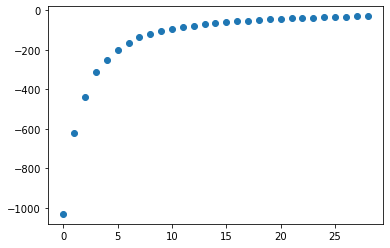

In [141]:
plt.plot(scores, 'o')

## Picking 10 clusters based on curve

In [142]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(bis_norm)
kmeans.score(bis_norm)

-106.95647379809243

## Print number of examples per cluster

In [143]:
[(kmeans.labels_ == i).nonzero()[0].shape for i in range(n_clusters)]

[(151,),
 (414,),
 (329,),
 (227,),
 (234,),
 (660,),
 (517,),
 (133,),
 (243,),
 (108,)]

## Plot histograms of dot products
This roughly gives a range of overlap

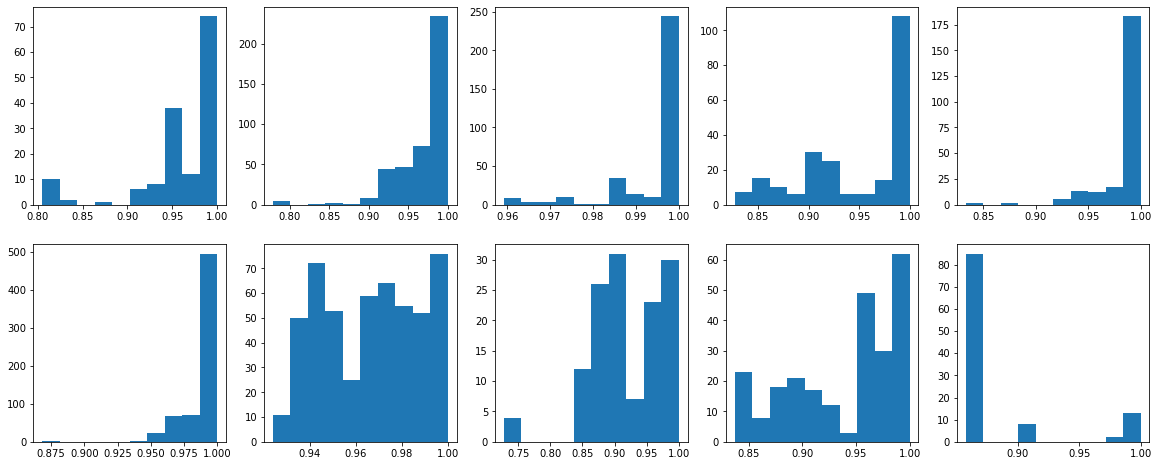

In [144]:
n_rows, n_cols = 2, 5
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20,8))
for i in range(n_rows):
    for j in range(n_cols):
        bis_norms_for_label = bis_norm[(kmeans.labels_ == 5 * i + j).nonzero()[0]]
        dots = bis_norms_for_label @ bis_norm[(kmeans.labels_ == 5 * i + j).nonzero()[0]][0].reshape(1, -1).T
        ax[i, j].hist(dots.T)

## We can use the following to visualize

In [219]:
i = 9
bis_norms_for_label = bis_norm[(kmeans.labels_ == i).nonzero()[0]]
dots = bis_norms_for_label @ bis_norm[(kmeans.labels_ == i).nonzero()[0][0]].reshape(1, -1).T

In [220]:
min_val, min_ind = torch.min(dots.reshape(-1), axis=-1)
max_val, max_ind = torch.max(dots.reshape(-1), axis=-1)

In [221]:
print(min_val, max_val)

tensor(0.8578) tensor(1.)


In [222]:
min_ind_all = (kmeans.labels_ == i).nonzero()[0][min_ind]
max_ind_all = (kmeans.labels_ == i).nonzero()[0][max_ind]

### Biggest mismatch with 0th entry of cluster

In [223]:
# env = all_envs[min_ind_all]
# go.Figure([go.Scatter3d(x=env[:, 0], y=env[:, 1], z=env[:, 2], mode="markers"), 
#            go.Scatter3d(x=[0.], y=[0.], z=[0.])])

In [224]:
go.Figure([go.Surface(**sph.plotly_surface(AgS[min_ind_all].to(torch.float32))[0])])

### 0th entry of cluster

In [225]:
# env = all_envs[max_ind_all]
# go.Figure([go.Scatter3d(x=env[:, 0], y=env[:, 1], z=env[:, 2], mode="markers"), 
#            go.Scatter3d(x=[0.], y=[0.], z=[0.])])

In [226]:
go.Figure([go.Surface(**sph.plotly_surface(AgS[max_ind_all].to(torch.float32))[0])])

## Plot bispectra

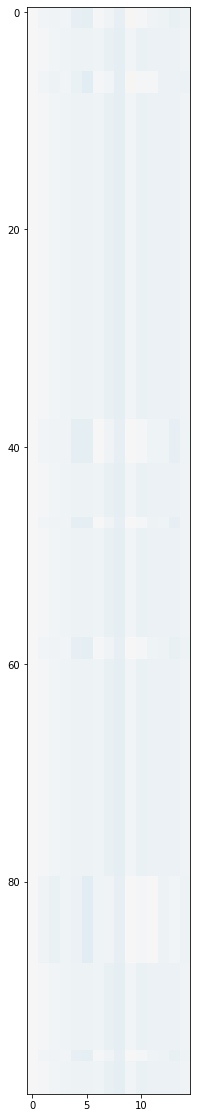

In [227]:
vmax = 5
plt.figure(figsize=(10, 20))
plt.imshow(bis_norm[(kmeans.labels_ == i).nonzero()][:100], cmap='RdBu', vmin=-vmax, vmax=vmax)